# Assignment 5. Tools for Machine Learning Workflow

*Foundations of Data Science*  
*Dr. Khalaj (Fall 2023)*  

*For your questions refer to @amirsoleix on Telegram*

### Description  
One of the applications that rises frequently in machine learning projects is classification. A sector where intensively uses classification is retrieval on large data banks mostly by using queries on the previously categorized data. For example, indexing in search engines helps fast retrieval of relevant data, or in e-commerce platforms, appropriate categorization and placement of filters is necessary for better user experience. It allows customers to access their relevant goods with ease, making the platform more profitable.  

In this homework, we want to classify the software, games, etc. available on `downloadha.com`. The website started as a modest delivery network for software, but has since evolved into a precious repository for all kinds of applications for different operating systems and platforms.  

### Information  
Complete the information box below.

In [1]:
full_name = 'Danial'
student_id = 'Ataie'

## 1 Retrieval of Data

Consider a content delivery website. On the user end, when you want to find what you want in such websites, you probably use the search bar or the navigation menu on the top, or alternatively, let Google find you the best matching result using its proprietary indexing (which by the way, usually works better than the website's own search bar!).  

But as a data engineer, the level of detail and comprehensiveness of data matters more as you are looking for insight rather than single matches. It allows you to analyze different aspects of social behavior on different localities and make informed decisions based on that.  

Consider that you are a data analyst for a software team given the task of analyzing market demand for your upcoming product. In this scenario, one of the best ways is to track activity on forums and goto places where people get their software from. This can range from different online stores and websites, to community forums and related social media posts.  

After discussion, you have found that `downloadha.com` is one of the main sources local people use for downloading their software hence you want to analyze the demand for different categories of softwares.

### 1.1 Data Version Control
Since data is constantly changing, logging the current state of the data is a necessity. It is required that we track the changes and act upon them when necessary, and a prerequisite to knowing when changes occur is to be aware of what changes are logged in our systems and what changes are not. One of the tools used for version controlling the data is `DVC`. Read the documents and use it in the process.

In [4]:
# ! pip install dvc

     ---------------------------------------- 0.0/41.8 kB ? eta -:--:--
     ----------------------------- ---------- 30.7/41.8 kB 1.4 MB/s eta 0:00:01
     ---------------------------------------- 41.8/41.8 kB 1.0 MB/s eta 0:00:00
     ---------------------------------------- 0.0/154.5 kB ? eta -:--:--
     ------- ------------------------------- 30.7/154.5 kB 1.3 MB/s eta 0:00:01
     -------------- ---------------------- 61.4/154.5 kB 812.7 kB/s eta 0:00:01
     ----------------- ------------------- 71.7/154.5 kB 787.7 kB/s eta 0:00:01
     -------------------------- --------- 112.6/154.5 kB 726.2 kB/s eta 0:00:01
     ------------------------------------ 154.5/154.5 kB 767.6 kB/s eta 0:00:00
     ---------------------------------------- 0.0/45.9 kB ? eta -:--:--
     ---------------------------------------- 0.0/45.9 kB ? eta -:--:--
     ---------------------------------------- 0.0/45.9 kB ? eta -:--:--
     ---------------------------------------- 0.0/45.9 kB ? eta -:--:--
     --

ERROR: Could not install packages due to an OSError: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\Dan\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages\\dulwich\\tests\\test_greenthreads.py'
Consider using the `--user` option or check the permissions.



In [5]:
import dvc

### 1.2 Crawling

List the information related to each software for the last 1000 softwares listed on the mentioned website. The website uses pagination with 10 results available on each page. So for reaching 1000 softwares you need to crawl `downloadha.com/page/1/` up to `downloadha.com/page/100/`. For having a safety threshold in case of crawler failure (a common problem in crawlers), you can extend it to 2000 items to be sure you are left with 1000 decent instances.  

This website is chosen in particular for its easy access to database. Remember that as systems gets more advanced accessing older data becomes harder. For comparison try to search for books that were listed on Amazon before 2020 and look at the URL!  

The data for each software should include:
- Name
- Platform
- Category and Subcategories
- Description
- Date of Creation
- Author
- Visit Count
- Comment Count
- Tags

Save the data on a CSV file and upload it with your delivery. You can use libraries like Beautiful Soup and Scrapy for the crawling task.

In [6]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

In [7]:
# Needed functions
import re

def extract_game_name_and_platform(url):
    # Extract the part of the URL that contains the game name and platform
    match = re.search(r'/game/(.+?)-(\w+)/?$', url)
    if match:
        # Replace hyphens with spaces and title case the name
        game_name = match.group(1).replace('-', ' ').title()
        platform = match.group(2).upper()  # Convert platform to uppercase
        return game_name, platform
    else:
        return "Could not extract info", "Unknown"
    
def extract_author(url):
    if not url.startswith('https://www.downloadha.com/author/'):
        return "Invalid URL format for author extraction."

    parts = url.rstrip('/').split('/')
    author_name = parts[-1]  # The author's name is the last part of the URL
    return author_name

def extract_visit_count(text):
    # Extract digits, including commas
    match = re.search(r'[\d,]+', text)
    if match:
        # Remove commas and convert to integer
        numeric_part = match.group().replace(',', '')
        return int(numeric_part)
    else:
        return None

def convert_persian_numbers_to_english(persian_number):
    persian_numerals = '۰۱۲۳۴۵۶۷۸۹'
    english_numerals = '0123456789'
    translation_table = str.maketrans(persian_numerals, english_numerals)
    return persian_number.translate(translation_table)

def extract_comment_count(text):
    if 'بدون نظر' in text:
        return 0
    else:
        # Extract Persian numbers
        match = re.search(r'[\d۰۱۲۳۴۵۶۷۸۹]+', text)
        if match:
            persian_number = match.group()
            return int(convert_persian_numbers_to_english(persian_number))
        else:
            return None

def extract_tags(text):
    # Remove the initial part of the string ("برچسب ها:" or "برچسب‌ها:")
    clean_text = text.replace('برچسب ها:', '').replace('برچسب‌ها:', '').strip()
    # Split the tags by comma
    tags = clean_text.split(', ')
    return tags

In [10]:
from tqdm import tqdm

all_articles = []

for i in tqdm(range(1, 301)):
    url = f"https://www.downloadha.com/page/{i}/"
    response = requests.get(url=url)
    response = response.content
    soup = BeautifulSoup(response, 'html.parser')
    main = soup.find('main')
    articles = main.find_all('article')
    for article in articles:
        title_element = article.find('h2', class_="entry-title")
        url = title_element.find('a')['href'] if title_element and title_element.find('a') else "URL not found"
        name, platform = extract_game_name_and_platform(url)

        dirty_categories = article.find_all('a', rel="category tag")
        categories = [category.get_text() for category in dirty_categories if category]

        description_element = article.find('p', style='text-align: justify;')
        description = description_element.text if description_element else "Description not available"

        footer = article.find('footer')
        if footer:
            time_element = footer.find('time', class_='entry-date published')
            time = time_element.text if time_element else "Time not available"

            author_url_element = footer.find('a', class_='url fn n')
            author_url = author_url_element['href'] if author_url_element else "Author URL not found"
            author = extract_author(author_url)

            visit_count_element = footer.find('div', class_='post-view inline-block')
            visit_count_dirty = visit_count_element.text if visit_count_element else "0"
            visit_count = extract_visit_count(visit_count_dirty)

            comment_count_elements = footer.find_all('div', class_='post-view inline-block')
            comment_count_dirty = comment_count_elements[1].text if len(comment_count_elements) > 1 else "0"
            comment_count = extract_comment_count(comment_count_dirty)

            tags_dirty = footer.find('div', class_="post-tags")
            tags = extract_tags(tags_dirty.text) if tags_dirty else []

        article_data = {
            'Title': name,
            'Platform': platform,
            'Categories': categories,
            'Description': description,
            'Publication Time': time,
            'Author': author,
            'Visit Count': visit_count,
            'Comment Count': comment_count,
            'Tags': tags
        }
        all_articles.append(article_data)


100%|██████████| 300/300 [07:18<00:00,  1.46s/it]


In [11]:
df = pd.DataFrame(all_articles)
csv_file = "softwares_data.csv"
df.to_csv(csv_file, index=False, encoding='utf-8')
df.head()

,Title,Platform,Categories,Description,Publication Time,Author,Visit Count,Comment Count,Tags
0,The Talos Principle,2,"[بازی کامپیوتر, بازی ماجرایی, پلتفرمر, معمایی]",بازی The Talos Principle 2 از همان ابتدا به شم...,۱۴۰۲/۱۱/۰۹,behnam,10103,4.0,"[بازی AAA, دانلود The Talos Principle 2, دانلو..."
1,Against The,STORM,"[بازی استراتژیک, بازی کامپیوتر, شبیه سازی]",در بازی Against the Storm در نقش نایب السلطنه ...,۱۴۰۲/۱۱/۰۹,hosein,7487,0.0,"[بازی AAA, پیش نمایش بازی Against the Storm, د..."
2,Bomb Rush,CYBERFUNK,"[بازی اکشن, بازی کامپیوتر, بازی ماجرایی, پلتفرمر]",بازی Bomb Rush Cyberfunk در آینده‌ای نزدیک جری...,۱۴۰۲/۱۱/۰۹,behnam,1005,0.0,"[دانلود Bomb Rush Cyberfunk, دانلود بازی Bomb ..."
3,Coral,ISLAND,"[بازی کامپیوتر, بازی ماجرایی, شبیه سازی]",بازی Coral Island این فرصت را به شما می‌دهد که...,۱۴۰۲/۱۱/۰۹,hosein,6708,0.0,"[بازی AAA, بازی Coral Island, دانلود بازی Cora..."
4,Dave The,DIVER,"[بازی اکشن, بازی کامپیوتر, بازی ماجرایی]",در بازی Dave the Diver قرار است که دریایی محسو...,۱۴۰۲/۱۱/۰۹,hosein,15204,3.0,"[بازی AAA, بازی Dave the Diver, پیش نمایش بازی..."


In [12]:
df.shape

(3000, 9)

### 1.3 Database (Bonus)  
Use a relational database like MySQL, SQLite or a non-relational instance like MongoDB for archiving the data. You don't need online implementation of this and can create a local instance of database and upload the relevant files with your delivery.

In [25]:
import sqlite3

# Connect to SQLite database (or create it if it doesn't exist)
conn = sqlite3.connect('games_data.db')
cursor = conn.cursor()

# Create a table
cursor.execute('''
    CREATE TABLE IF NOT EXISTS games (
        Title TEXT,
        Platform TEXT,
        Categories TEXT,
        Description TEXT,
        PublicationTime TEXT,
        Author TEXT,
        VisitCount INTEGER,
        CommentCount INTEGER,
        Tags TEXT
    )
''')
conn.commit()

# Read data from CSV
df = pd.read_csv('softwares_data.csv')

# Convert lists in 'Categories' and 'Tags' columns to strings
df['Categories'] = df['Categories'].apply(lambda x: ', '.join(eval(x)) if isinstance(x, str) else x)
df['Tags'] = df['Tags'].apply(lambda x: ', '.join(eval(x)) if isinstance(x, str) else x)

# # Write data to SQLite database
df.to_sql('games', conn, if_exists='replace', index=False)

conn.close()

## 2 Exploratory Data Analysis

Report the information about the data in charts. This includes converting the data into a consistent format, including the dates, descriptions, etc.  

More attention needs to be put toward the default categorization the website has provided. As it is given in a breadcrumb format, you need to breakdown the category to extract different levels. You need to deliver the following data/visualizations for this part:

- Graph of different categories and subcategories of the softwares available on the website. Some of the material listed might not be software but videos. For those, use the default category of the website to create a new section. **Treat videos, educational packages, etc. just as other categories of software. Do not exclude them from the data.**

In [30]:
# Split the 'Categories' column into a list of categories
df['Categories'] = df['Categories'].apply(lambda x: x.split(', ') if isinstance(x, str) else x)

In [40]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data = df

# Translation of Persian categories into English
category_translation = {
    'آرکید': 'Arcade',
    'آشپزی': 'Cooking',
    'آموزش زبان': 'Language Learning',
    'آموزشی': 'Educational',
    'آیفون': 'iPhone',
    'ابزار اینترنت': 'Internet Tools',
    'ابزارها': 'Tools',
    'استراتژیک': 'Strategic',
    'انیمیشن سریالی': 'Animated Series',
    'اول شخص': 'First Person',
    'ایندی': 'Indie',
    'بازی': 'Game',
    'بازی PS4': 'PS4 Game',
    'بازی PS4 VR': 'PS4 VR Game',
    'بازی PS5': 'PS5 Game',
    'بازی آنلاین رایگان': 'Free Online Game',
    'بازی استراتژیک': 'Strategic Game',
    'بازی اندروید': 'Android Game',
    'بازی اکشن': 'Action Game',
    'بازی فکری': 'Puzzle Game',
    'بازی ماجرایی': 'Adventure Game',
    'بازی ماشین سواری': 'Racing Game',
    'بازی ورزشی': 'Sports Game',
    'بازی کامپیوتر': 'Computer Game',
    'بازی کنسول': 'Console Game',
    'بازی کودکان': 'Children\'s Game',
    'برنامه نویسی': 'Programming',
    'تجارت و بازاریابی': 'Business and Marketing',
    'ترسناک': 'Horror',
    'تصویری': 'Visual',
    'تلاش برای بقا': 'Survival',
    'تکنولوژی': 'Technology',
    'جهان آزاد': 'Open World',
    'حیات وحش': 'Wildlife',
    'خشونت آمیز': 'Violent',
    'خودرو و موتور': 'Cars and Motorcycles',
    'روانشناسی': 'Psychology',
    'ساخت بازی': 'Game Development',
    'سایر': 'Other',
    'سایر سیستم عامل ها': 'Other Operating Systems',
    'سخت افزار': 'Hardware',
    'سلامت': 'Health',
    'سوم شخص': 'Third Person',
    'سیستم عامل ویندوز': 'Windows Operating System',
    'شبکه': 'Network',
    'شبیه سازی': 'Simulation',
    'شوتر': 'Shooter',
    'صوتی': 'Audio',
    'ضبط صفحه نمایش': 'Screen Recording',
    'طراحی وب': 'Web Design',
    'علمی': 'Scientific',
    'فانتزی': 'Fantasy',
    'فرهنگ و هنر': 'Culture and Art',
    'مالتی مدیا': 'Multimedia',
    'مجله': 'Magazine',
    'مخفی کاری': 'Stealth',
    'مراسم': 'Ceremony',
    'مسنجر و پیغام رسان': 'Messenger and Chat',
    'معماری و دکوراسیون': 'Architecture and Decoration',
    'معمایی': 'Mystery',
    'موبایل': 'Mobile',
    'موزیک خارجی': 'Foreign Music',
    'موسیقی متن': 'Soundtrack',
    'موسیقی متن بازی': 'Game Soundtrack',
    'موسیقی متن فیلم': 'Movie Soundtrack',
    'نرم افزار': 'Software',
    'نرم افزار آفیس': 'Office Software',
    'نرم افزار آموزشی': 'Educational Software',
    'نرم افزار اندروید': 'Android Software',
    'نرم افزار اینترنت': 'Internet Software',
    'نرم افزار برنامه نویسی': 'Programming Software',
    'نرم افزار تبدیل کننده': 'Converter Software',
    'نرم افزار طراحی': 'Design Software',
    'نرم افزار فشرده ساز': 'Compression Software',
    'نرم افزار مالتی مدیا': 'Multimedia Software',
    'نرم افزار مبدل': 'Converter Software',
    'نرم افزار مدیریت دانلود': 'Download Manager Software',
    'نرم افزار مدیریت دسکتاپ': 'Desktop Management Software',
    'نرم افزار مرورگر وب': 'Web Browser Software',
    'نرم افزار مهندسی': 'Engineering Software',
    'نرم افزار موبایل': 'Mobile Software',
    'نرم افزار ویرایشگر': 'Editing Software',
    'نرم افزار پخش کننده': 'Player Software',
    'نرم افزار کاربردی': 'Utility Software',
    'نرم افزار گرافیک': 'Graphic Software',
    'نرم افزارهای مک': 'Mac Software',
    'نقش آفرینی': 'Role Playing',
    'واقعیت مجازی VR': 'Virtual Reality VR',
    'والپیپر': 'Wallpaper',
    'ورزشی': 'Sports',
    'ویرایش عکس': 'Photo Editing',
    'ویرایش فیلم': 'Video Editing',
    'ویرایشگر صوت و تصویر': 'Audio and Video Editor',
    'پارکور': 'Parkour',
    'پلاگین': 'Plugin',
    'پلتفرمر': 'Platformer',
    'کتاب الکترونیک': 'E-book',
    'کلیپ های ورزشی': 'Sports Clips',
    'کژوال': 'Casual',
    'گرافیک': 'Graphics'
}


def translate(lst):
    return [category_translation.get(cat, cat) for cat in lst]


# Translate categories in the dataset
translated_categories = []
for categories_list in data['Categories']:
    translated_categories.extend(translate(categories_list))

c:\Users\Dan\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Dan\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Dan\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
c:\Users\Dan\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be

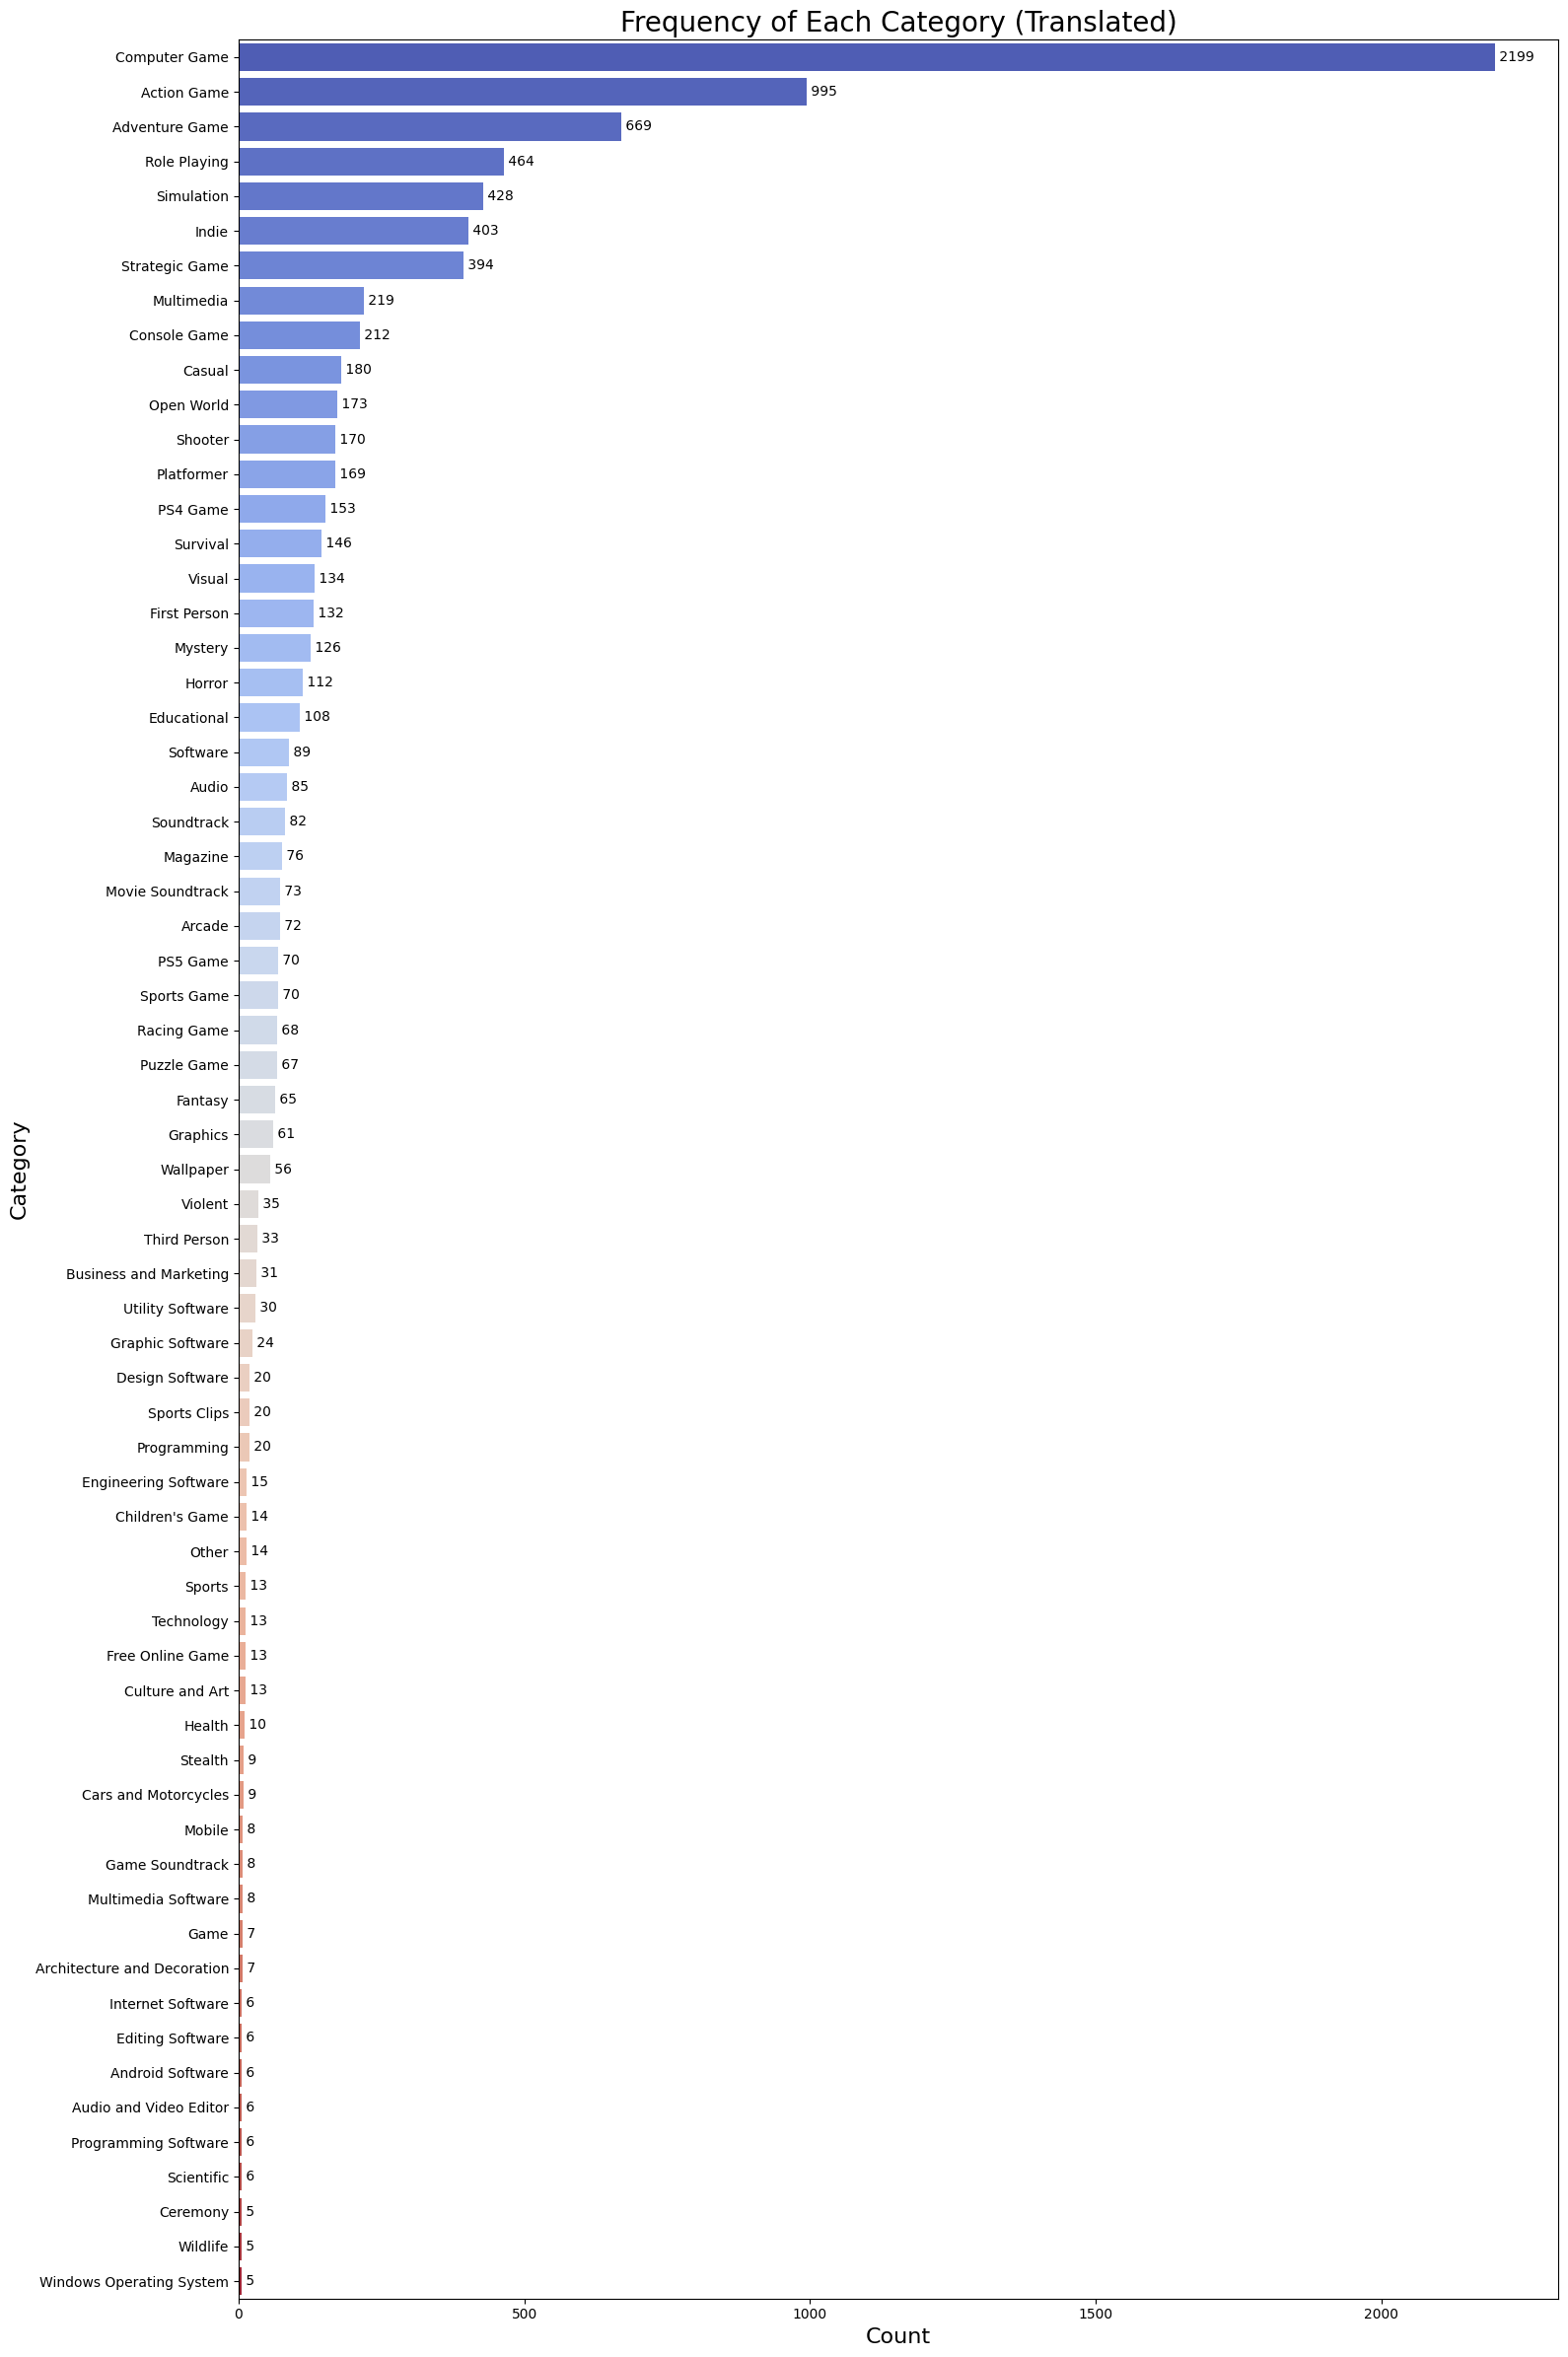

In [41]:
# Count the frequency of each translated category
translated_category_counts = pd.Series(translated_categories).value_counts()
# Getting only the important ones (those with more than 5 frequency)
translated_category_counts = translated_category_counts[translated_category_counts.values >= 5]
categories = translated_category_counts.index.tolist()
counts = translated_category_counts.values

# Creating a bar plot for translated category frequencies
plt.figure(figsize=(16, 24))
palette = sns.color_palette("coolwarm", len(categories))
sns.barplot(x=counts, y=categories, palette=palette)
for i, value in enumerate(counts):
    plt.text(value, i, f' {value}', va='center')

plt.title('Frequency of Each Category (Translated)', fontsize=20)
plt.xlabel('Count', fontsize=16)
plt.ylabel('Category', fontsize=16)
plt.tight_layout()
plt.show()

In [42]:
# Create a new column for the translated categories
data['Categories (English)'] = data['Categories'].apply(translate)

# Drop the original Persian 'Categories' column
data.drop('Categories', axis=1, inplace=True)

- Frequency of softwares provided for different platforms and operating systems including but not limited to PS5, Windows, Linux, MacOS X.

In [43]:
data['Platform']

0               2
1           STORM
2       CYBERFUNK
3          ISLAND
4           DIVER
          ...    
2995        TIDES
2996      Unknown
2997      MATTERS
2998           PC
2999        SQUAD
Name: Platform, Length: 3000, dtype: object

In [44]:
platform_keywords = {
    'PC': ['Computer Game', 'Compression Software'],
    'iOS': ['iPhone'],
    'PS5': ['PS5 Game'],
    'Console': ['Console Game'],
    'Android': ['Android Game', 'Android Software'],
    'Mac': ['Mac Software', 'MacOS'],
    'Linux': ['Linux'],
    'PS4': ['PS4 VR Game', 'PS4 Game'],
    'mobile': ['Mobile Software']
}

# Function to determine the platform based on categories
def determine_platform(categories_str):
    if isinstance(categories_str, str):
        categories = eval(categories_str)
    else:
        categories = categories_str  # Assuming it's already a list if not a string
    
    for platform, keywords in platform_keywords.items():
        if any(keyword in categories for keyword in keywords):
            return platform
    return 'Other'  # Default value if no platform-specific keyword is found


data['Platform'] = data['Categories (English)'].apply(determine_platform)
data.head()

,Title,Platform,Description,Publication Time,Author,Visit Count,Comment Count,Tags,Categories (English)
0,The Talos Principle,PC,بازی The Talos Principle 2 از همان ابتدا به شم...,۱۴۰۲/۱۱/۰۹,behnam,10103,4.0,"بازی AAA, دانلود The Talos Principle 2, دانلود...","[Computer Game, Adventure Game, Platformer, My..."
1,Against The,PC,در بازی Against the Storm در نقش نایب السلطنه ...,۱۴۰۲/۱۱/۰۹,hosein,7487,0.0,"بازی AAA, پیش نمایش بازی Against the Storm, دا...","[Strategic Game, Computer Game, Simulation]"
2,Bomb Rush,PC,بازی Bomb Rush Cyberfunk در آینده‌ای نزدیک جری...,۱۴۰۲/۱۱/۰۹,behnam,1005,0.0,"دانلود Bomb Rush Cyberfunk, دانلود بازی Bomb R...","[Action Game, Computer Game, Adventure Game, P..."
3,Coral,PC,بازی Coral Island این فرصت را به شما می‌دهد که...,۱۴۰۲/۱۱/۰۹,hosein,6708,0.0,"بازی AAA, بازی Coral Island, دانلود بازی Coral...","[Computer Game, Adventure Game, Simulation]"
4,Dave The,PC,در بازی Dave the Diver قرار است که دریایی محسو...,۱۴۰۲/۱۱/۰۹,hosein,15204,3.0,"بازی AAA, بازی Dave the Diver, پیش نمایش بازی ...","[Action Game, Computer Game, Adventure Game]"


c:\Users\Dan\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Dan\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Dan\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


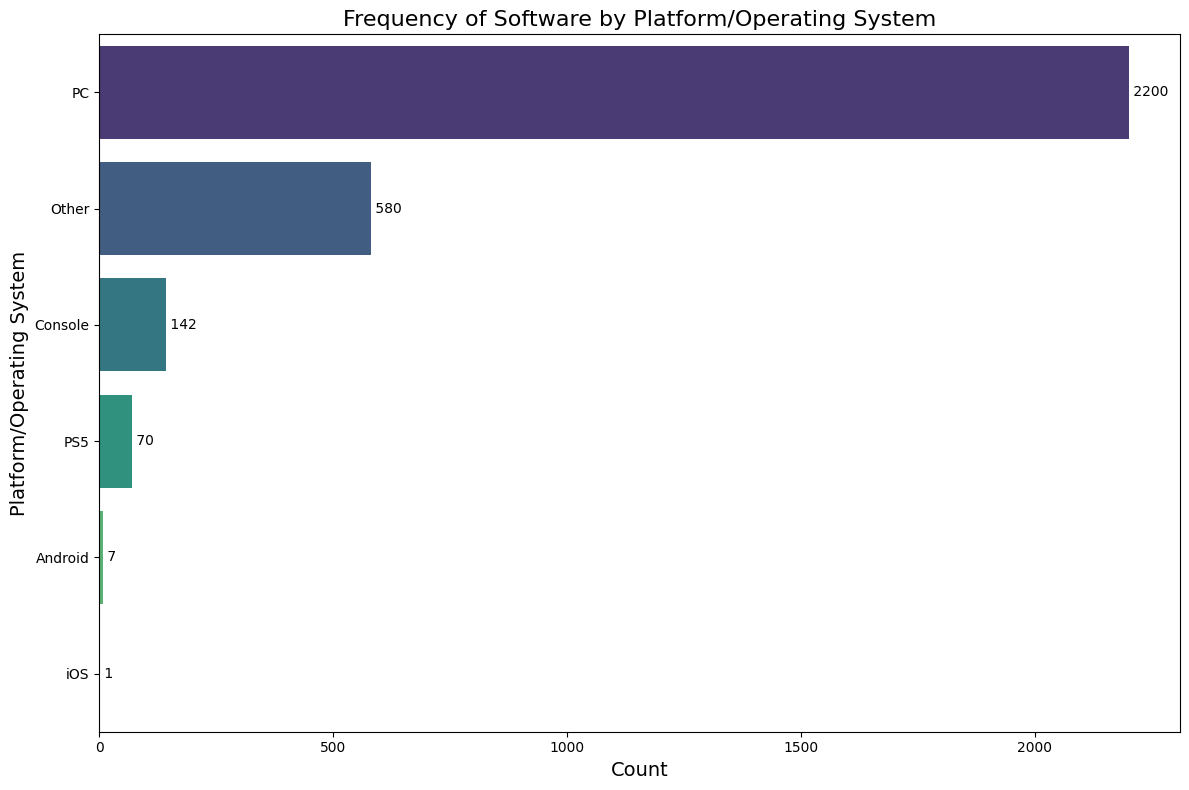

In [45]:
# Counting the frequency of each platform
platform_counts = data['Platform'].value_counts()

plt.figure(figsize=(12, 8))
palette = sns.color_palette("viridis", len(platform_counts))
sns.barplot(x=platform_counts.values, y=platform_counts.index, palette=palette)
for i, value in enumerate(platform_counts.values):
    plt.text(value, i, f' {value}', va='center')
plt.title('Frequency of Software by Platform/Operating System', fontsize=16)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Platform/Operating System', fontsize=14)
plt.tight_layout()
plt.show()

In [46]:
data.to_csv('Data.csv', index=False, encoding='utf-8')

## 3 Classification Beyond the Website

Now its time to extract the insights we need. For this part, you are free to use whichever technique, algorithm and library you desire. Just remember that the notebook should be able to provide the result locally, so avoid using online systems. Deliver the following items:

- Classify different categories of software and identify the top 5 hottest software categories and subcategories on the website based on the number of reviews and visits of softwares in that category. Explain your process and reasoning along with your results.

In [98]:
import ast

# Read the data
data = pd.read_csv('Data.csv')
# Convert the list column from string to list
data['Categories (English)'] = data['Categories (English)'].apply(ast.literal_eval)

# Expand categories with associated counts
rows = []
for _, row in data.iterrows():
    for category in row['Categories (English)']:
        rows.append({
            'Category': category,
            'Visit Count': row['Visit Count'],
            'Comment Count': row['Comment Count']
        })
expanded_data = pd.DataFrame(rows)

# Calculate a simple hotness score
expanded_data['Hotness Score'] = expanded_data['Visit Count'] + 10 * expanded_data['Comment Count']

# Aggregate scores by category
category_scores = expanded_data.groupby('Category')['Hotness Score'].sum()

# Rank categories
top_categories = category_scores.sort_values(ascending=False)

# Showing the top 5 categories
print(top_categories.head())

Category
Computer Game     35277809.0
Action Game       22157674.0
Adventure Game    11596231.0
Role Playing       7901894.0
Software           7812946.0
Name: Hotness Score, dtype: float64


- Your team wants to contact the admins of the website directly. Using the `author` field you gathered previously, find out which individuals are responsible for posting softwares of different categories. This is done by matching the authors with categories and finding out the `author`s most responsible for the latest posts in different categories. As an example, you may find that 70 percent of PS5 action games are posted by **John Doe**, so it is probable that this individual is tasked with finding out the latest games of PS5 and posting them on the website.

In [99]:
import jdatetime

# Removing the invalid dates
persian_digits = ['۰', '۱', '۲', '۳', '۴', '۵', '۶', '۷', '۸', '۹']
data = data[data['Publication Time'].apply(lambda x: str(x).startswith(tuple(persian_digits)))]

# Converting the Publication Time column to a datetime column
def convert_persian_date(date):
    persian_digits2 = {
        '۰': '0', '۱': '1', '۲': '2', '۳': '3', '۴': '4',
        '۵': '5', '۶': '6', '۷': '7', '۸': '8', '۹': '9'
    }
    western_date = ''.join(persian_digits2.get(ch, ch) for ch in date)
    year, month, day = map(int, western_date.split('/'))
    gregorian_date = jdatetime.date(year, month, day).togregorian()
    return gregorian_date

data['Publication Time1'] = data['Publication Time'].apply(convert_persian_date)
data.drop('Publication Time', axis=1, inplace=True)
data.rename(columns={'Publication Time1': 'Publication Time',},inplace=True)

Now the dates are fixed and are usable for our analysis.

In [100]:
# Finding the top authors for recent posts
# We will consider the posts since 2023
data['Publication Time'] = pd.to_datetime(data['Publication Time'])
data_recent = data[data['Publication Time'].dt.year >= 2023]

rows = []
for _, row in data_recent.iterrows():
    for category in row['Categories (English)']:
        rows.append({
            'Author': row['Author'],
            'Category': category,
        })

expanded_data = pd.DataFrame(rows)

# Group by Categories and Authors
grouped_data = expanded_data.groupby(['Category', 'Author']).size().reset_index(name='Post Count')

# Finding the top authors for each category
top_authors_per_category = grouped_data.sort_values('Post Count', ascending=False).groupby('Category').head(1)
top_authors_per_category.reset_index(inplace=True, drop=True)

print(top_authors_per_category)

                Category  Author  Post Count
0          Computer Game  behnam        1049
1            Action Game  behnam         443
2         Adventure Game  behnam         298
3           Role Playing  behnam         253
4             Simulation  behnam         210
..                   ...     ...         ...
72               Network  behnam           1
73       Office Software  behnam           1
74           PS4 VR Game  hosein           1
75                Plugin   admin           1
76  Programming Software   admin           1

[77 rows x 3 columns]


- Find out and list five the sources you think the softwares and videos of the website are gathered from. Since `downloadha.com` is not a producer nor a developer, its objective is gathering different softwares from different vendors in one place. And it is most likely that it uses other websites as its source. Using the descriptions and analyzing it for entity names, it is possible to extract useful information about its possible sources. Explain your approach comprehensively and present your results.

In [101]:
from langdetect import detect
import langdetect

'''
We will use the python package spacy here. Since the name of the resources in this website are mostly english, we will
analyze the english text in the describtion and try to find the sources.
'''
def keep_english_words(text):
    words = text.split()
    english_words = []
    for word in words:
        try:
            if detect(word) == 'en':
                english_words.append(word)
        except langdetect.lang_detect_exception.LangDetectException:
            pass
    return ' '.join(english_words)

# Apply the function to the Description column
data['Description_English'] = data['Description'].apply(keep_english_words)

# Now 'Description_English' will have only English words

Now we will analyze the english tokens with NER using spacy library

In [102]:
import spacy
from collections import Counter

nlp = spacy.load('en_core_web_sm')

def extract_entities(description):
    doc = nlp(description)
    return [ent.text for ent in doc.ents]

data['Entities'] = data['Description_English'].apply(extract_entities)

# Flatten the list of entities and count occurrences
all_entities = [entity for sublist in data['Entities'] for entity in sublist]
entity_counts = Counter(all_entities)

# Display the most common entities
print(entity_counts.most_common(5))

[('One', 10), ('House', 7), ('Tactics', 5), ('Earth', 4), ('River City', 4)]
